In [1]:
!pip install pwlf

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
import pwlf

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.preprocessing import maxabs_scale
from sklearn.metrics import r2_score

from scipy.optimize import nnls, lsq_linear, least_squares
from scipy.interpolate import splev, splrep

%matplotlib inline

In [3]:
# random state
rs = 4

# Data

Gathering and preparation of the data to be inputed into the model.

The countries were selected in the EDA file, populations were taken from https://worldpopulationreview.com/countries.

In [4]:
# Spain, UK, Italy, Germany...
cc_dict = {
    'ARG': 'Argentina', 'AUS': 'Australia',  
    'CHN': 'China',     'CZE': 'Czechia',    
    'EGY': 'Egypt',     'FIN': 'Finland',
    'HND': 'Honduras',  'IND': 'India',
    'JPN': 'Japan',     'NOR': 'Norway',
    'RUS': 'Russia',    'SWE': 'Sweden',
    'THA': 'Thailand',  'USA': 'US'
}

# cc_dict = {
#     'BEL': 'Belgium',      'CMR': 'Cameroon',    'DOM': 'Dominican Republic',
#     'EGY': 'Egypt',        'IRQ': 'Iraq',        'JOR': 'Jordan',
#     'MLI': 'Mali',         'MWI': 'Malawi',      'NLD': 'Netherlands',
#     'POL': 'Poland',       'SSD': 'South Sudan', 'TUN': 'Tunisia',
#     'ZAF': 'South Africa', 'ZMB': 'Zambia',      'ZWE': 'Zimbabwe'
# }

pop_dict = { # 2020 population
    'ARG': 45195774,   'AUS': 25499884, 
    'CHN': 1439323776, 'CZE': 10708981,   
    'EGY': 102334404,  'FIN': 5540720,  
    'HND': 9904607,    'IND': 1380004385, 
    'JPN': 126476461,  'NOR': 5421241,  
    'RUS': 145934462,  'SWE': 10099265,
    'THA': 69799978,   'USA': 331002651
}

# pop_dict = {
#     'BEL': 11589623,  'CMR': 26545863, 'DOM': 10847910,
#     'EGY': 102334404, 'IRQ': 40222493, 'JOR': 10203134,
#     'MLI': 20250833,  'MWI': 19129952, 'NLD': 17134872,
#     'POL': 37846611,  'SSD': 11193725, 'TUN': 11818619,
#     'ZAF': 59308690,  'ZMB': 18383955, 'ZWE': 14862924
# }

## Virus

Virus propagation data is obtained from the CSSE at Johns Hopkins University.

In [5]:
url_cases = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_death = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recov = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [6]:
jhu_cases = pd.read_csv(url_cases)
jhu_death = pd.read_csv(url_death)
jhu_recov = pd.read_csv(url_recov)

Remove global registries from countries with subregional registies and the sum up these subregional cases.

In [7]:
sel_reg = ['Netherlands', 'United Kingdom', 'France', 'Denmark']

def remove_global_registry(jhu_df):
  'Remove global country records when local ones exist.'
  a = jhu_df['Country/Region'].isin(sel_reg)
  b = jhu_df['Province/State'].isna()
  cond = pd.DataFrame([a, b]).all()
  idx = jhu_df[cond].index
  jhu_df.drop(idx, axis=0, inplace=True)

# remove global Netherlands, UK, France and Denmark
remove_global_registry(jhu_cases)
remove_global_registry(jhu_death)
remove_global_registry(jhu_recov)
# drop subregion, latitude and longitude columns
jhu_cases.drop(jhu_cases.columns[[0, 2, 3]], axis=1, inplace=True)
jhu_death.drop(jhu_death.columns[[0, 2, 3]], axis=1, inplace=True)
jhu_recov.drop(jhu_recov.columns[[0, 2, 3]], axis=1, inplace=True)

print('cases shape:',      jhu_cases.shape)
print('deaths shape:',     jhu_death.shape)
print('recoveries shape:', jhu_recov.shape)

cases shape: (276, 675)
deaths shape: (276, 675)
recoveries shape: (261, 675)


In [8]:
# reshape dfs
jhu_cases = jhu_cases.groupby('Country/Region').sum()
jhu_cases = jhu_cases.T # transpose columns / rows
jhu_cases.index = pd.to_datetime(jhu_cases.index)
jhu_death = jhu_death.groupby('Country/Region').sum()
jhu_death = jhu_death.T # transpose columns / rows
jhu_death.index = pd.to_datetime(jhu_death.index)
jhu_recov = jhu_recov.groupby('Country/Region').sum()
jhu_recov = jhu_recov.T # transpose columns / rows
jhu_recov.index = pd.to_datetime(jhu_recov.index)

print('cases shape:',      jhu_cases.shape)
print('deaths shape:',     jhu_death.shape)
print('recoveries shape:', jhu_recov.shape)

cases shape: (674, 196)
deaths shape: (674, 196)
recoveries shape: (674, 196)


Create separate dataframes containing data on countries of interest only. Apply a smoothing average to the curves. Use them to compute further variables (compartments) needed to represent the compartmental model.

In [9]:
window = 7

In [10]:
# the rationale behind setting the labels at the center of the window:
# cases are reported with different delay
cum_cases = jhu_cases[cc_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_deaths = jhu_death[cc_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_recoveries = jhu_recov[cc_dict.values()].rolling(window, min_periods=1, center=True).mean()

In [11]:
R = cum_deaths + cum_recoveries
I = cum_cases - R
S = pop_dict.values() - cum_cases

In [12]:
r_prop = R / pop_dict.values()
i_prop = I / pop_dict.values()
s_prop = S / pop_dict.values()

### Initial approximation

Operate with the proportional compartments; $s, i, r$. Analyse the beginning of the pandemic, assuming $\lim_{t\rightarrow0}s\rightarrow1$. Therefore, study the change of the growth rate $gr=\log{i_2}-\log{i_1}=\beta-\gamma$.

In [13]:
# handle log(0)
warnings.filterwarnings('ignore', category=RuntimeWarning)
log_i = np.log(i_prop)
warnings.resetwarnings()
# before the pandemic begins, the growth must be zero
log_i[np.isinf(log_i)] = 0

In [14]:
gr = log_i[1:] - log_i[:-1].values # different index

### Transmission coefficient computation

Operate with the relative compartments to save operations. Only assuming independence with time (same as last time), study $\beta=\frac{gr+\gamma}{s}=\frac{(\log{i_2}-\log{i_1})+\gamma}{s}$. An alternative path to the transmission rate is $\beta=\frac{\log{s_1}-\log{s_2}}{i}$. This has the advantage of not having to deal with values $\log0$, which we were classifying as $0$.

Because the SIR model (instead of the SEIR model) is being used, the resulting transmission coefficient will be small.

In [15]:
# dr_dt = r_prop[1:] - r_prop[:-1].values # different index
# gamma = dr_dt / i_prop[1:]
# gamma[np.isinf(gamma)] = np.nan # division by zero
# gamma[gamma.isna()] = 0         # before the pandemic begins
# beta = (gr + gamma) / s_prop[1:]

In [16]:
# the alternative formula
log_s = np.log(S)
diff_log = log_s[:-1].values - log_s[1:] # same index as other variables
beta = diff_log / I

## Policy

We focus on policies aimed at obstructing the spread of the virus. The Oxford group considers four types of measures:

*   Containment
*   Economic
*   Health system
*   Miscellaneous

Here containment- and some health system-related measures are considered.

In [17]:
url_pol = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'

oxcgrt = pd.read_csv(url_pol, dtype={'RegionName': str, 'RegionCode': str})

oxcgrt.drop(oxcgrt.columns[37:], axis=1, inplace=True) # indexes and extra

oxcgrt['Date'] = pd.to_datetime(oxcgrt['Date'], format='%Y%m%d')

Policy implementation is available at state level in some countries.

In [18]:
oxcgrt_sub = oxcgrt[oxcgrt['Jurisdiction'] == 'STATE_TOTAL'].copy()

In [19]:
# region information
oxcgrt.drop(oxcgrt.columns[[2, 3]], axis=1, inplace=True)

oxcgrt = oxcgrt[oxcgrt['Jurisdiction'] == 'NAT_TOTAL']
oxcgrt

,CountryName,CountryCode,Jurisdiction,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people
0,Aruba,ABW,NAT_TOTAL,2020-01-01,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
1,Aruba,ABW,NAT_TOTAL,2020-01-02,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
2,Aruba,ABW,NAT_TOTAL,2020-01-03,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
3,Aruba,ABW,NAT_TOTAL,2020-01-04,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
4,Aruba,ABW,NAT_TOTAL,2020-01-05,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217459,Zimbabwe,ZWE,NAT_TOTAL,2021-11-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217460,Zimbabwe,ZWE,NAT_TOTAL,2021-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217461,Zimbabwe,ZWE,NAT_TOTAL,2021-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217462,Zimbabwe,ZWE,NAT_TOTAL,2021-11-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The Oxford dataset contains earlier dates compared to the JHU dataset.

In [20]:
print('Virus data: ', jhu_cases.index.min(), '-', jhu_cases.index.max())
print('Policy data:', oxcgrt['Date'].min(), '-', oxcgrt['Date'].max())

Virus data:  2020-01-22 00:00:00 - 2021-11-25 00:00:00
Policy data: 2020-01-01 00:00:00 - 2021-11-27 00:00:00


Pivot the data to obtain a different dataset for each policy type indexed by time (date).

In [21]:
idch = list(oxcgrt.columns[4:19:2])
idch.append(oxcgrt.columns[24])
idch.append(oxcgrt.columns[30])

C1 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[0])
C2 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[1])
C3 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[2])
C4 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[3])
C5 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[4])
C6 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[5])
C7 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[6])
C8 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[7])
H1 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[8])
H6 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[9])

CH_X = [C1, C2, C3, C4, C5, C6, C7, C8, H1, H6]
 
idch

['C1_School closing',
 'C2_Workplace closing',
 'C3_Cancel public events',
 'C4_Restrictions on gatherings',
 'C5_Close public transport',
 'C6_Stay at home requirements',
 'C7_Restrictions on internal movement',
 'C8_International travel controls',
 'H1_Public information campaigns',
 'H6_Facial Coverings']

# Model

Development of the model(s) and results.

## Auxiliar

Confidence intervals:
https://apmonitor.com/che263/index.php/Main/PythonRegressionStatistics

In [22]:
# aux vars
ta = gr.index.min()
tb = gr.index.max()

chx_str = [s.split('_')[0] for s in idch]

In [23]:
# check starting date
ta == beta.index.min()

False

In [24]:
# aux fns
def _get_init_date(iso):
  name = cc_dict[iso]
  t_idx = cum_cases.loc[cum_cases[name] > 25, name].index
  return t_idx.min()

def data_from(iso, t0, t1, tr, t_d, y):
  'Select data with location and time constraints.'

  if iso in cc_dict.keys():
    name = cc_dict[iso]
  elif iso in tot_dict.keys():
    name = tot_dict[iso]
  else:
    raise NameError('Invalid ISO code.')
  
  if not t0:
    t0 = _get_init_date(iso)
  if t0 < ta:
    t0 = ta # previous value NA otherwise
  
  if not t1:
    if not tr:
      raise ValueError('Provide end of time range (either t1 or tr).')
    prop_case = cum_cases[name] / pop_dict[iso]
    t1 = prop_case[prop_case < tr/100].index.max()

  delay = pd.to_timedelta(t_d, unit='days')
  ch_x = [ch.loc[t0 - delay:t1 - delay, iso] for ch in CH_X]
  pol_t = pd.concat(ch_x, axis=1, ignore_index=True)
  
  y_t = y.loc[t0:t1, name]
  
  return pol_t, y_t

# to do: specific for each of the two label types
def preprocess(pol_t, y_t):
  'Transform data to feed the model.'
  
  pol_t.fillna(method='pad', inplace=True) # back fill
  pol_t.fillna(value=0, inplace=True)      # if no previous value available
  pol_norm = maxabs_scale(pol_t[1:])       # match vars length at scaling
  y_norm = maxabs_scale(y_t)

  # policy combinations
  # poly = PolynomialFeatures(degree=2, interaction_only=True)
  # pol_comb = poly.fit_transform(pol_norm)
  # comb_str = poly.get_feature_names(chx_str)
  # day-of-the-week
  # day = y_t[1:].index.weekday.values.reshape(-1, 1)
  # ohe = OneHotEncoder(sparse=False).fit_transform(day)
  # ohe_str = [f'weekday {d+1}' for d in range(7)]
  # previous 
  td1 = y_norm[:-1].reshape(-1, 1)
  # group data
  arr = np.hstack([pol_norm, td1])
  col = np.append(chx_str, 'prev')
  df = pd.DataFrame(arr, columns=col)

  # label = pd.Series(y_norm[1:], index=y_t[1:].index) # date ref
  
  return df, y_norm[1:]

def _print_model(name, value, score):
  print('Coefficients\n------------')
  for n, v in zip(name, value):
    if v != 0:
      print('{:s} : {:3f}'.format(n, v))
  print('\nR^2\n---')
  print(round(score, 3))

## Initial model

Uses the groth rate, $gr=\beta-\gamma$, as label. Conditioned on the restriction $s\rightarrow1$, it reaches a different time range depending on the country.

Customized grid of values for the parameters.

Compare the linear regression and Lasso stability of coefficients.

The code is:

```
cv_flag = True
y_df = gr_smooth
cv_arr = []
grid = {'tr': [0.5, 0.75, 1, 2, 3], 'delay': [7, 10, 14, 18, 21]}
lin = LinearRegression()
# lasso = LassoLarsCV(cv=KFold(shuffle=True), max_iter=3, eps=.1**7)
# lasso = LassoCV(cv=KFold(shuffle=True), max_iter=10**5)
for cc in cc_dict:
  cv_cc = []
  for par in list(ParameterGrid(grid)):
    cv_par = []
    X_raw, y_raw = data_from(cc, tr=par['tr'], t_d=par['delay'], y=y_df)
    X, y = preprocess(X_raw, y_raw)
    if cv_flag:
      # cross-validation
      kf = KFold(shuffle=True)
      cv_kf = []
      for train_idx, test_idx in kf.split(X):
        fit = lin.fit(X.values[train_idx], y.values[train_idx])
        kf_score = fit.score(X.values[test_idx], y.values[test_idx])
        cv_kf.append(kf_score)
        score = np.asarray(cv_kf).mean()
    else:
      # train-test
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
      score = lin.fit(X_train, y_train).score(X_test, y_test)
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr
```

The LARS implementation of Lasso is much faster and it was used for the CV loop. However, the number of regressors needs to be restricted due to convergency issues and the general accuracy obtained is lower compared to the standard *brute force* Lasso. Therefore, the LARS implementation it is not used anymore.

Using cross-validation on all available data, can yield sizeable negative values (sometimes) while performing least squares. Filter those values or assign value zero.

In [25]:
y_df = gr
cv_arr = []
grid = {'tr': [0.1, 0.25, 0.5, 1, 2.5], 'delay': [9, 12, 15, 18, 21]}
lin = LinearRegression()
for cc in cc_dict:
  cv_cc = []
  for par in list(ParameterGrid(grid)):
    X_raw, y_raw = data_from(cc, None, None, par['tr'], par['delay'], y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lin.fit(X.iloc[train_idx], y[train_idx])
      kf_score = fit.score(X.iloc[test_idx], y[test_idx])
      cv_kf.append(kf_score)
      # to do: filter negative values
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([-2.61501137e+25,  8.21481883e-01,  7.79205845e-01, -1.67169917e+25,
       -3.66704324e+24,  8.39778908e-01,  8.12584106e-01,  7.81549996e-01,
        7.98175596e-01,  7.55030588e-01, -1.55842929e+23,  8.19618265e-01,
       -1.62081693e+25,  8.01302039e-01,  7.56370391e-01, -4.25921244e+24,
        8.25228390e-01,  7.80767651e-01,  8.07425227e-01,  7.61467063e-01,
        8.42239776e-01, -1.16115084e+25, -7.84513182e+23,  8.08851136e-01,
       -1.12435535e+20])

In [26]:
cv_arr.mean()

-3.1821402944449594e+24

In [27]:
y_df = gr
cv_arr = []
grid = {'tr': [0.1, 0.25, 0.5, 1, 2.5], 'delay': [9, 12, 15, 18, 21]}
lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
for cc in cc_dict:
  cv_cc = []
  for par in list(ParameterGrid(grid)):
    X_raw, y_raw = data_from(cc, None, None, par['tr'], par['delay'], y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lasso.fit(X.iloc[train_idx], y[train_idx])
      kf_score = fit.score(X.iloc[test_idx], y[test_idx])
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([0.83920919, 0.80482134, 0.77024906, 0.7893936 , 0.75471011,
       0.84339043, 0.81109856, 0.77456577, 0.7908921 , 0.75517804,
       0.82964843, 0.81157521, 0.76701363, 0.78961835, 0.75463296,
       0.84540728, 0.81595578, 0.7700991 , 0.79289646, 0.75667273,
       0.84797656, 0.81482797, 0.77094261, 0.79284091, 0.75772991])

In [28]:
cv_arr.mean()

0.7940538441738276

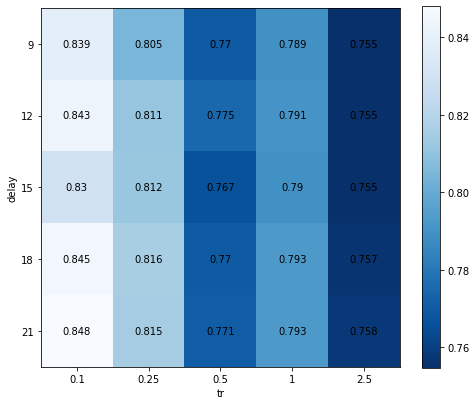

In [29]:
cv_mat = cv_arr.reshape(5, 5)
# heatmap
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(X=cv_mat, cmap='Blues_r') # 
# colorbar
ax.figure.colorbar(im, ax=ax, shrink=0.75)
# axis titles
ax.set_xlabel('tr')
ax.set_ylabel('delay')
# show all ticks...
ax.set_xticks(np.arange(len(grid['tr'])))
ax.set_yticks(np.arange(len(grid['delay'])))
# ...and label them
ax.set_xticklabels(grid['tr'])
ax.set_yticklabels(grid['delay'])
# loop over data dimensions and create text annotations
for i in range(len(grid['tr'])):
  for j in range(len(grid['delay'])):
    text = ax.text(j, i, round(cv_mat[i, j], ndigits=3), ha="center", va="center")
fig.tight_layout()
plt.show()

In [30]:
def initial_model(region, tr=.1, delay=15, print=False):
  '''Policy effect on cases based on linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - tr (float) : percentage (%) treshold for applying the approximation.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  X_raw, y_raw = data_from(region, None, None, tr, delay, gr)
  X, y = preprocess(X_raw, y_raw)
  coef_names = X.columns.values
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=rs
  )

  lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
  lasso.fit(X_train, y_train)
  score = lasso.score(X_test, y_test)

  reg = Lasso(alpha=lasso.alpha_).fit(X, y)
  coef_values = reg.coef_

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return reg, X, y, score

In [31]:
coef = []; r_sq = [];
for k in cc_dict.keys():
  m_k, X_k, y_k, r_k = initial_model(k)
  coef.append(m_k.coef_[:-1])
  r_sq.append(r_k)

Performance ($R^2$) for the chosen parameteres.

In [32]:
np.asarray(r_sq).mean()

0.9131346970112862

In [33]:
np.asarray(r_sq).var()

0.012107996965167867

In [34]:
for r_i in r_sq:
  print(round(r_i, 2))

0.94
0.97
0.55
0.98
0.93
0.9
0.95
0.8
0.95
0.96
0.98
0.99
0.94
0.94


Global effect of each policy.

In [35]:
coef = np.asarray(coef).mean(axis=0)
for string, value in zip(idch, coef):
  name = string.split('_')[1]
  print(f'{name:33} -> {value:5f}')

School closing                    -> -0.013348
Workplace closing                 -> -0.003659
Cancel public events              -> -0.024201
Restrictions on gatherings        -> -0.008880
Close public transport            -> -0.006269
Stay at home requirements         -> -0.004044
Restrictions on internal movement -> -0.024878
International travel controls     -> -0.007308
Public information campaigns      -> -0.038089
Facial Coverings                  -> -0.012363


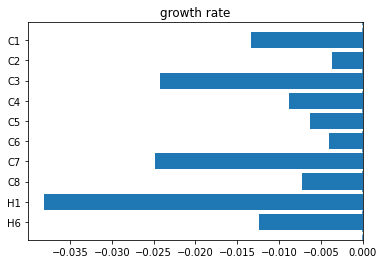

In [36]:
plt.barh(chx_str[::-1], coef[::-1]) # flip order
plt.axvline(ls='--')
plt.title('growth rate')
plt.show()

In [37]:
for i in idch:
  print(i.replace('_', ' >> '))

C1 >> School closing
C2 >> Workplace closing
C3 >> Cancel public events
C4 >> Restrictions on gatherings
C5 >> Close public transport
C6 >> Stay at home requirements
C7 >> Restrictions on internal movement
C8 >> International travel controls
H1 >> Public information campaigns
H6 >> Facial Coverings


Textual representation of the model for one country.

In [38]:
idx = 10 # country index
cci = list(cc_dict.keys())[idx]
initial_model(cci, print=True)

Coefficients
------------
C1 : -0.006861
C2 : -0.017024
C5 : -0.049305
C6 : -0.000000
C7 : -0.047764
H1 : -0.035327
prev : 0.724532

R^2
---
0.976


Visual representation of the model.

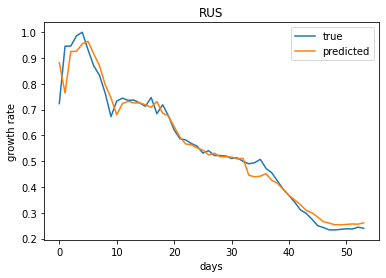

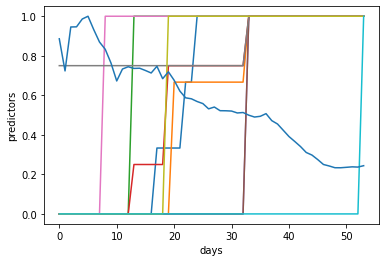


Number of data points: 54
Number of variables: 11


In [39]:
model, X, y = initial_model(cci)[:3]

plt.plot(y, label='true')
plt.plot(model.predict(X), label='predicted')
plt.xlabel('days')
plt.ylabel('growth rate')
plt.title(cci)
plt.legend()
X.plot(legend=False)
plt.xlabel('days')
plt.ylabel('predictors')
plt.show()

print('\nNumber of data points:', X.shape[0])
print('Number of variables:', X.shape[1])

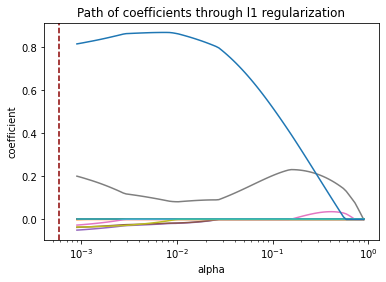

In [40]:
alphas, coefs = model.path(X, y)[:2]
alpha = model.get_params()['alpha']
for coef in coefs:
  plt.semilogx(alphas, coef)
plt.axvline(alpha, ls='--', color='darkred')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.title('Path of coefficients through l1 regularization')
plt.show()

## Transmission model

It uses the transmission rate, $\beta$, as label. The linear function is fitted in thiner time segments.

Parameter grid search.

In [41]:
# mm-dd-yyyy format
t_init = pd.to_datetime('06-01-2020')
t_end = t_init + pd.to_timedelta(60, unit='days')

In [42]:
y_df = beta
cv_arr = []
grid = range(7, 21) # delay
lin = LinearRegression()
for cc in cc_dict:
  cv_cc = []
  for par in grid:
    X_raw, y_raw = data_from(cc, t_init, t_end, tr=None, t_d=par, y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lin.fit(X.iloc[train_idx], y[train_idx])
      kf_score = fit.score(X.iloc[test_idx], y[test_idx])
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([ 8.98907914e-01,  8.97806335e-01,  8.97012834e-01,  8.98828452e-01,
       -5.60411176e+22,  8.96279491e-01,  8.96478258e-01,  8.97191306e-01,
        8.93503721e-01,  8.95334386e-01,  8.95861981e-01,  8.97572861e-01,
        8.96555873e-01,  8.97123130e-01])

In [43]:
cv_arr.mean()

-4.0029369701932697e+21

In [44]:
y_df = beta
cv_arr = []
grid = range(1, 21) # delay
lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
for cc in cc_dict:
  cv_cc = []
  for par in grid:
    X_raw, y_raw = data_from(cc, t_init, t_end, tr=None, t_d=par, y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lasso.fit(X.iloc[train_idx], y[train_idx])
      kf_score = fit.score(X.iloc[test_idx], y[test_idx])
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([0.89541491, 0.89713401, 0.89560824, 0.89295012, 0.90433791,
       0.90165505, 0.89978438, 0.89693873, 0.89662947, 0.89812229,
       0.89693752, 0.8930856 , 0.89388756, 0.8948672 , 0.89304772,
       0.89276503, 0.89575077, 0.89853576, 0.89824936, 0.89809167])

In [45]:
cv_arr.mean()

0.8966896650577578

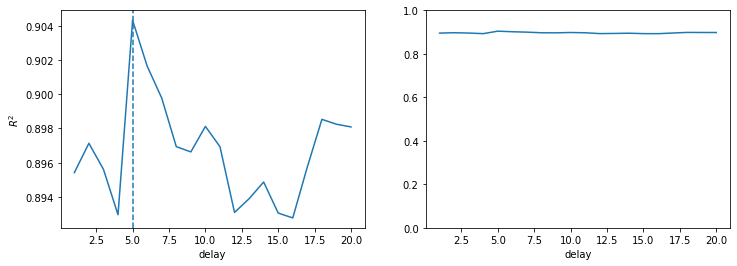

In [47]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].plot(grid, cv_arr)
axs[0].axvline(grid[cv_arr.argmax()], ls='--')
axs[0].set_xlabel('delay')
axs[0].set_ylabel('$R^2$')
axs[1].plot(grid, cv_arr, scaley=False)
axs[1].set_xlabel('delay')
plt.show()

In [48]:
def linear_model(region, delay=12, print=False):
  '''Policy effect on cases based on linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  # divide the pandemic into subranges
  ta_i = _get_init_date(region)
  t_idx = pd.date_range(start=ta_i, end=tb, freq='2M')

  X = []; y = []; reg = []; score = []; coef_values = []
  # apply the model to each subrange
  lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
  for i in range(len(t_idx) - 2):
    X_raw, y_raw = data_from(region, t_idx[i], t_idx[i + 1], None, delay, beta)
    X_i, y_i = preprocess(X_raw, y_raw)
    X_train, X_test, y_train, y_test = train_test_split(
        X_i, y_i, test_size=0.2, random_state=rs
    )

    lasso.fit(X_train, y_train)
    score_i = lasso.score(X_test, y_test)

    reg_i = Lasso(alpha=lasso.alpha_).fit(X_i, y_i)
    coef_values_i = reg_i.coef_
    
    # aggregate model results
    X.append(X_i)
    y.append(y_i)
    score.append(score_i)
    reg.append(reg_i)
    coef_values.append(coef_values_i)
  
  score = np.asarray(score).mean()
  coef_values = np.asarray(coef_values).mean(axis=0)
  coef_names = X_i.columns.values

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return reg, X, y, score

In [49]:
coef_glob = []; coef_intv = []; r_sq = [];
for k in cc_dict.keys():
  m_k, X_k, y_k, r_k = linear_model(k)
  # each model is defined in segments (invervals)
  coef_k = [lasso.coef_[:-1] for lasso in m_k]
  coef_glob.append(np.asarray(coef_k).mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))                    # individual
  r_sq.append(r_k)

Performance ($R^2$) for the chosen parameters. Is computed from the testing set.

In [50]:
np.asarray(r_sq).mean()

0.9090523879986041

In [51]:
np.asarray(r_sq).var()

0.004275903216528294

In [52]:
for r_i in r_sq:
  print(round(r_i, 2))

0.88
0.95
0.91
0.94
0.98
0.92
0.76
0.91
0.93
0.93
0.98
0.89
0.77
0.97


*Global* values for the coefficients of each policy type.

In [53]:
coef_glob = np.asarray(coef_glob).mean(axis=0)
for string, value in zip(idch, coef_glob):
  name = string.split('_')[1]
  print(f'{name:33} -> {value:5f}')

School closing                    -> 0.001622
Workplace closing                 -> 0.000192
Cancel public events              -> -0.002247
Restrictions on gatherings        -> -0.006663
Close public transport            -> -0.002187
Stay at home requirements         -> -0.003668
Restrictions on internal movement -> 0.002094
International travel controls     -> -0.000460
Public information campaigns      -> -0.000671
Facial Coverings                  -> -0.003399


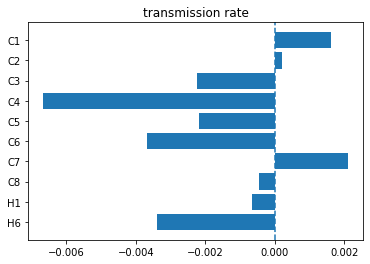

In [54]:
plt.barh(chx_str[::-1], coef_glob[::-1]) # flip order
plt.axvline(ls='--')
plt.title('transmission rate')
plt.show()

*Interval*-wise values for the coefficients of each policy type. They are meant to represent the coefficients at different stages of the pandemic.

In [55]:
# can't convert to array directly: variable interval size
# (arrays have fixed length)
# need to traverse the whole nested list...
n = len(coef_intv)         # fixed (no. countries)
m = np.zeros(n, dtype=int) # variable (no. intervals)
l = len(chx_str)           # fixed (no. policies)
for i in range(n):
  m[i] = len(coef_intv[i])

dim = m.max()
# ...and fill empty positions as NaN
for v in coef_intv:
  if(len(v) < dim):
    v += [[np.nan] * l] * (dim - len(v))

In [56]:
coef_intv = np.asarray(coef_intv)
print(coef_intv.shape)
coef_intv = coef_intv.mean(axis=0)
print(coef_intv.shape)

(14, 9, 10)
(9, 10)


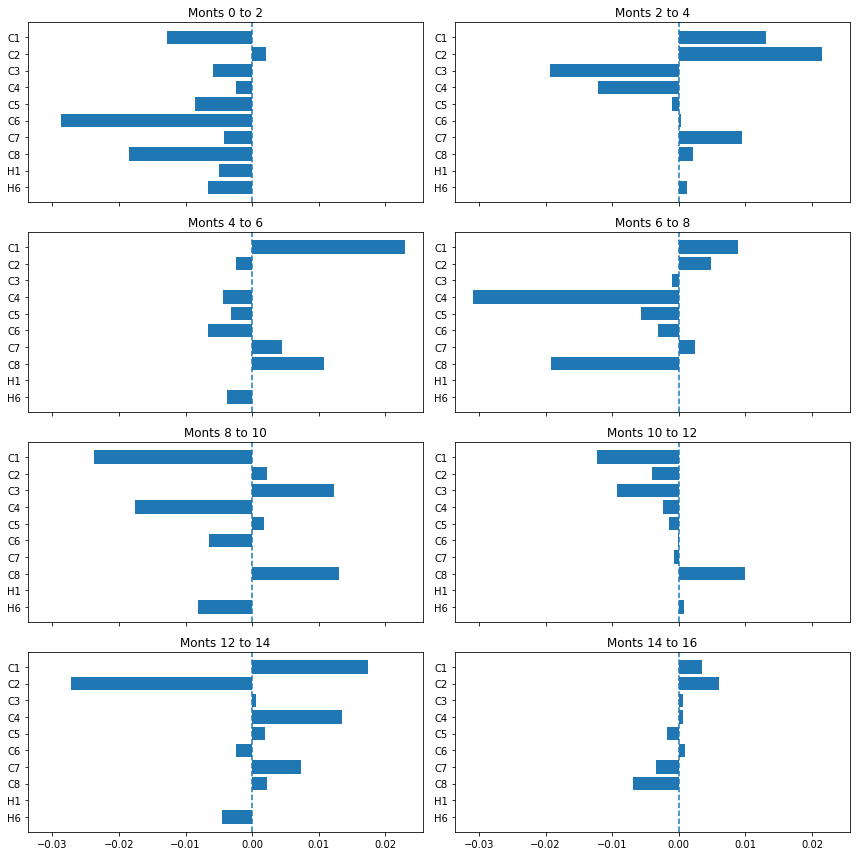

In [57]:
fig, axs = plt.subplots(nrows=dim//2, ncols=2, sharex=True, figsize=(12, 12))

n = 0
# don't use the last interval with less samples
for intv in coef_intv[:-1]:
  axs[n//2, n%2].barh(chx_str[::-1], intv[::-1]) # flip order
  axs[n//2, n%2].axvline(ls='--')
  axs[n//2, n%2].set_title('Monts {} to {}'.format(n*2, (n+1)*2))
  n += 1

fig.tight_layout()
fig.show()

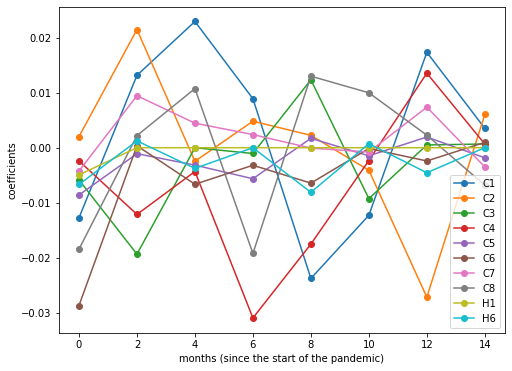

In [58]:
size_ratio = 1.25
plt.figure(figsize=[6.4*size_ratio, 4.8*size_ratio])
plt.plot(range(0, dim * 2, 2), coef_intv, 'o-')
plt.xlabel('months (since the start of the pandemic)')
plt.ylabel('coefficients')
plt.legend(chx_str)
plt.show()

In [59]:
for i in idch:
  print(i.replace('_', ' >> '))

C1 >> School closing
C2 >> Workplace closing
C3 >> Cancel public events
C4 >> Restrictions on gatherings
C5 >> Close public transport
C6 >> Stay at home requirements
C7 >> Restrictions on internal movement
C8 >> International travel controls
H1 >> Public information campaigns
H6 >> Facial Coverings


Textual representation of single country model.

In [60]:
idx = 10 # country index
cci = list(cc_dict.keys())[idx]
linear_model(cci, print=True)

Coefficients
------------
C1 : 0.003052
C2 : -0.001556
C3 : 0.001849
C4 : 0.000536
C5 : -0.001063
C6 : -0.001182
C7 : 0.002051
C8 : -0.002905
H6 : 0.004477
prev : 0.968308

R^2
---
0.98


Resulting predictions of the model.

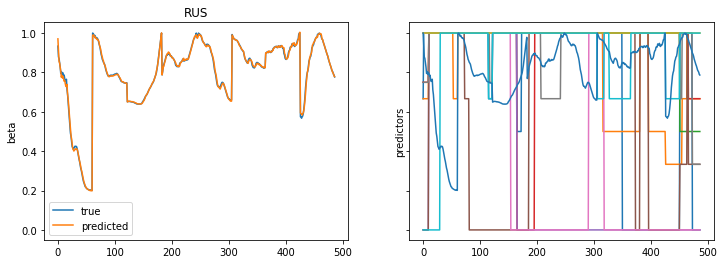

In [61]:
models, Xs, ys = linear_model(cci)[:3]

preds = []
for model, X, y in zip(models, Xs, ys):
  pred_i = model.predict(X)
  preds.append(pred_i)

# array format
X = np.vstack(Xs)
y = np.concatenate(ys)
pred = np.concatenate(preds)

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(12, 4))
axs[0].plot(y, label='true')
axs[0].plot(pred, label='predicted')
axs[0].set_ylabel('beta')
axs[0].set_title(cci)
axs[0].legend()
axs[1].plot(X)
axs[1].set_ylabel('predictors')
plt.show()

## Constrained model

Uses the transmission rate, $\beta$, as label. The coefficients (in every segment) are forced to take negative values.

### Non-negative least squares

This is achieved by reversing the sign of the coefficients, $\theta$, and imposing a positive constrain, namely $\theta \ge 0$.

Parameter grid search.

In [62]:
y_df = -beta
cv_arr = []
grid = range(1, 21) # delay
for cc in cc_dict:
  cv_cc = []
  for par in grid:
    X_raw, y_raw = data_from(cc, t_init, t_end, tr=None, t_d=par, y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = nnls(X.iloc[train_idx], y[train_idx])[0]
      kf_score = r2_score(y[test_idx], X.iloc[test_idx] @ fit)
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([0.89704731, 0.89695083, 0.89691578, 0.89701824, 0.89704684,
       0.89693282, 0.89682676, 0.89642936, 0.89638688, 0.89633596,
       0.89590008, 0.89566164, 0.89587988, 0.89617655, 0.89613171,
       0.89605464, 0.8960694 , 0.89620786, 0.89639722, 0.89660388])

In [63]:
cv_arr.mean()

0.8964486821339929

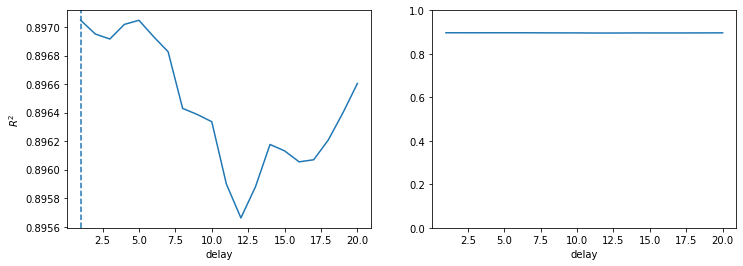

In [64]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].plot(grid, cv_arr)
axs[0].axvline(grid[cv_arr.argmax()], ls='--')
axs[0].set_xlabel('delay')
axs[0].set_ylabel('$R^2$')
axs[1].plot(grid, cv_arr, scaley=False)
axs[1].set_xlabel('delay')
plt.show()

In [65]:
def nnls_model(region, delay=12, print=False):
  '''Policy effect on cases based on constrained linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  # divide the pandemic into subranges
  ta_i = _get_init_date(region)
  t_idx = pd.date_range(start=ta_i, end=tb, freq='2M')

  X = []; y = []; score = []; coef = []
  # apply the model to each subrange
  for i in range(len(t_idx) - 2):
    X_raw, y_raw = data_from(region, t_idx[i], t_idx[i + 1], None, delay, -beta)
    X_i, y_i = preprocess(X_raw, y_raw)
    X_train, X_test, y_train, y_test = train_test_split(
        X_i, y_i, test_size=0.2, random_state=rs
    )

    coef_i = nnls(X_train, y_train)[0]

    y_pred = X_test @ coef_i # matrix multiplication
    score_i = r2_score(y_true=y_test, y_pred=y_pred)
    
    # aggregate model results
    X.append(X_i)
    y.append(y_i)
    score.append(score_i)
    coef.append(coef_i)
  
  score = np.asarray(score).mean()
  coef_values = np.asarray(coef).mean(axis=0)
  coef_names = X_i.columns.values

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return coef, X, y, score

In [66]:
coef_glob = []; coef_intv = []; r_sq = [];
for k in cc_dict.keys():
  c_k, X_k, y_k, r_k = nnls_model(k)
  # each model is defined in segments (invervals)
  coef_k = np.asarray(c_k)[:, :-1]
  coef_glob.append(coef_k.mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))        # individual
  r_sq.append(r_k)

Performance ($R^2$) for the chosen parameters. Is computed from the testing set.

In [67]:
np.asarray(r_sq).mean()

0.9049343002620219

In [68]:
np.asarray(r_sq).var()

0.004458605910559756

In [69]:
for r_i in r_sq:
  print(round(r_i, 2))

0.88
0.94
0.92
0.93
0.97
0.92
0.74
0.92
0.92
0.93
0.98
0.88
0.78
0.96


*Global* values for the coefficients of each policy type.

In [70]:
coef_glob = np.asarray(coef_glob).mean(axis=0)
for string, value in zip(idch, coef_glob):
  name = string.split('_')[1]
  print(f'{name:33} -> {value:5f}')

School closing                    -> 0.001112
Workplace closing                 -> 0.003998
Cancel public events              -> 0.001015
Restrictions on gatherings        -> 0.001463
Close public transport            -> 0.000452
Stay at home requirements         -> 0.001386
Restrictions on internal movement -> 0.001544
International travel controls     -> 0.001028
Public information campaigns      -> 0.000153
Facial Coverings                  -> 0.000677


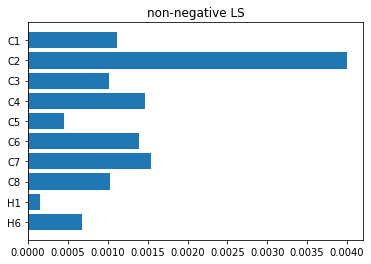

In [71]:
plt.barh(chx_str[::-1], coef_glob[::-1]) # flip order
plt.axvline(ls='--')
plt.title('non-negative LS')
plt.show()

### Linear least-squares with bounds

This optimization problem is convex, hence a found **minimum** (if iterations have converged) is guaranteed to be **global**.

In [72]:
# bound policy coefficients (only)
bounds = (-np.inf, [0] * len(chx_str) + [np.inf])

In [73]:
y_df = beta
cv_arr = []
grid = range(1, 21) # delay
for cc in cc_dict:
  cv_cc = []
  for par in grid:
    X_raw, y_raw = data_from(cc, t_init, t_end, tr=None, t_d=par, y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      # to do: use the last output of the function (success flag)
      # if(success == False): raise Exception
      fit = lsq_linear(X.iloc[train_idx], y[train_idx], bounds)['x']
      kf_score = r2_score(y[test_idx], X.iloc[test_idx] @ fit)
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([ 8.96538874e-01,  8.96439404e-01,  8.96915782e-01,  8.97018244e-01,
        8.96468819e-01,  8.96932826e-01,  8.96826759e-01,  8.96274556e-01,
       -1.25378566e+19,  8.96338956e-01,  8.95899976e-01,  8.95661646e-01,
        8.95881339e-01,  8.96177254e-01,  8.96131713e-01,  8.96056176e-01,
        8.96069388e-01,  8.96087093e-01,  8.96343799e-01,  8.96000229e-01])

In [74]:
cv_arr.mean()

-6.268928312402363e+17

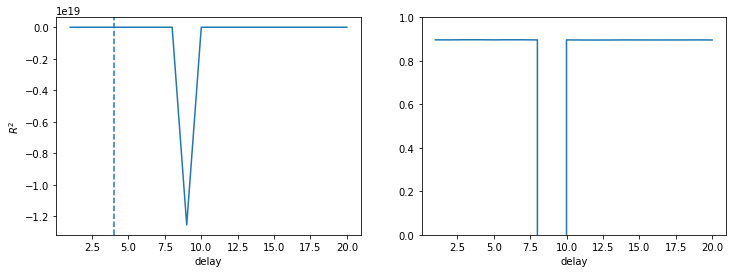

In [75]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].plot(grid, cv_arr)
axs[0].axvline(grid[cv_arr.argmax()], ls='--')
axs[0].set_xlabel('delay')
axs[0].set_ylabel('$R^2$')
axs[1].plot(grid, cv_arr, scaley=False)
axs[1].set_xlabel('delay')
plt.show()

In [76]:
def lsq_linear_model(region, delay=12, print=False):
  '''Policy effect on cases based on constrained linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  # divide the pandemic into subranges
  ta_i = _get_init_date(region)
  t_idx = pd.date_range(start=ta_i, end=tb, freq='2M')

  X = []; y = []; score = []; coef = []
  # apply the model to each subrange
  for i in range(len(t_idx) - 2):
    X_raw, y_raw = data_from(region, t_idx[i], t_idx[i + 1], None, delay, beta)
    X_i, y_i = preprocess(X_raw, y_raw)
    X_train, X_test, y_train, y_test = train_test_split(
        X_i, y_i, test_size=0.2, random_state=rs
    )

    coef_i = lsq_linear(X_train, y_train, bounds=bounds)['x']

    y_pred = X_test @ coef_i # matrix multiplication
    score_i = r2_score(y_true=y_test, y_pred=y_pred)
    
    # aggregate model results
    X.append(X_i)
    y.append(y_i)
    score.append(score_i)
    coef.append(coef_i)
  
  score = np.asarray(score).mean()
  coef_values = np.asarray(coef).mean(axis=0)
  coef_names = X_i.columns.values

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return coef, X, y, score

In [77]:
coef_glob = []; coef_intv = []; r_sq = [];
for k in cc_dict.keys():
  c_k, X_k, y_k, r_k = lsq_linear_model(k)
  # each model is defined in segments (invervals)
  coef_k = np.asarray(c_k)[:, :-1]
  coef_glob.append(coef_k.mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))        # individual
  r_sq.append(r_k)

In [78]:
np.asarray(r_sq).mean()

0.9049437911975062

In [79]:
np.asarray(r_sq).var()

0.004459882632879246

In [80]:
for r_i in r_sq:
  print(round(r_i, 2))

0.88
0.94
0.92
0.93
0.97
0.92
0.74
0.92
0.92
0.93
0.98
0.88
0.78
0.96


In [81]:
coef_glob = np.asarray(coef_glob).mean(axis=0)
for string, value in zip(idch, coef_glob):
  name = string.split('_')[1]
  print(f'{name:33} -> {value:5f}')

School closing                    -> -0.002183
Workplace closing                 -> -0.002949
Cancel public events              -> -0.001635
Restrictions on gatherings        -> -0.005219
Close public transport            -> -0.026803
Stay at home requirements         -> -0.008667
Restrictions on internal movement -> -0.014278
International travel controls     -> -0.001265
Public information campaigns      -> -0.000472
Facial Coverings                  -> -0.009874


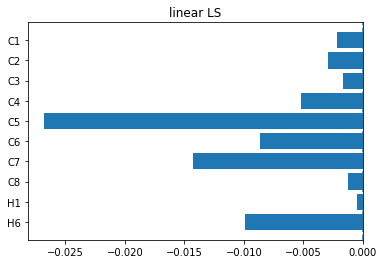

In [82]:
plt.barh(chx_str[::-1], coef_glob[::-1]) # flip order
plt.axvline(ls='--')
plt.title('linear LS')
plt.show()

### Non-linear least-squares with bounds

Given the residuals `fun(x)` (an m-D real function of n real variables) and the (optional) loss function `rho(s)` (a scalar function), `least_squares` finds a **local minimum** of the cost function.

In [83]:
# initial guess on independent variables
x0 = [0] * len(chx_str) + [1]
# computes the vector of residuals
def fun(x, A, y):
  return A @ x - y

In [84]:
y_df = beta
cv_arr = []
grid = range(1, 21) # delay
for cc in cc_dict:
  cv_cc = []
  for par in grid:
    X_raw, y_raw = data_from(cc, t_init, t_end, tr=None, t_d=par, y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      # to do: use the last output of the function (success flag)
      # if(success == False): raise Exception
      fit = least_squares(
          fun, x0, bounds=bounds, args=(X.iloc[train_idx], y[train_idx])
      )['x']
      kf_score = r2_score(y[test_idx], X.iloc[test_idx] @ fit)
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([-0.1339865 ,  0.38335351,  0.89691585,  0.89701824,  0.7842238 ,
        0.89693271,  0.89682706,  0.89642965,  0.89638706,  0.89633625,
        0.89590035,  0.89566192,  0.89588147,  0.89617668,  0.89613205,
        0.89605562,  0.89606953,  0.89615277,  0.89634288,  0.57823952])

In [85]:
cv_arr.mean()

0.7976525220441115

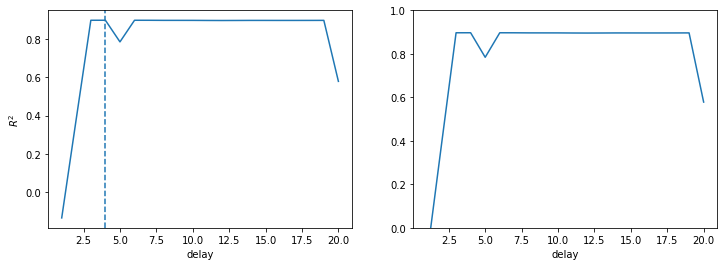

In [86]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].plot(grid, cv_arr)
axs[0].axvline(grid[cv_arr.argmax()], ls='--')
axs[0].set_xlabel('delay')
axs[0].set_ylabel('$R^2$')
axs[1].plot(grid, cv_arr, scaley=False)
axs[1].set_xlabel('delay')
plt.show()

In [87]:
def least_squares_model(region, delay=12, print=False):
  '''Policy effect on cases based on constrained linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  # divide the pandemic into subranges
  ta_i = _get_init_date(region)
  t_idx = pd.date_range(start=ta_i, end=tb, freq='2M')

  X = []; y = []; score = []; coef = []
  # apply the model to each subrange
  for i in range(len(t_idx) - 2):
    X_raw, y_raw = data_from(region, t_idx[i], t_idx[i + 1], None, delay, beta)
    X_i, y_i = preprocess(X_raw, y_raw)
    X_train, X_test, y_train, y_test = train_test_split(
        X_i, y_i, test_size=0.2, random_state=rs
    )

    coef_i = least_squares(fun, x0, bounds=bounds, args=(X_train, y_train))['x']

    y_pred = X_test @ coef_i # matrix multiplication
    score_i = r2_score(y_true=y_test, y_pred=y_pred)
    
    # aggregate model results
    X.append(X_i)
    y.append(y_i)
    score.append(score_i)
    coef.append(coef_i)
  
  score = np.asarray(score).mean()
  coef_values = np.asarray(coef).mean(axis=0)
  coef_names = X_i.columns.values

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return coef, X, y, score

In [88]:
coef_glob = []; coef_intv = []; r_sq = [];
for k in cc_dict.keys():
  c_k, X_k, y_k, r_k = least_squares_model(k)
  # each model is defined in segments (invervals)
  coef_k = np.asarray(c_k)[:, :-1]
  coef_glob.append(coef_k.mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))        # individual
  r_sq.append(r_k)

In [89]:
np.asarray(r_sq).mean()

0.9049660321676812

In [90]:
np.asarray(r_sq).var()

0.004462900599347304

In [91]:
coef_glob = np.asarray(coef_glob).mean(axis=0)
for string, value in zip(idch, coef_glob):
  name = string.split('_')[1]
  print(f'{name:33} -> {value:5f}')

School closing                    -> -0.001574
Workplace closing                 -> -0.002563
Cancel public events              -> -0.012645
Restrictions on gatherings        -> -0.114917
Close public transport            -> -0.642381
Stay at home requirements         -> -0.250334
Restrictions on internal movement -> -0.430560
International travel controls     -> -0.001214
Public information campaigns      -> -0.000466
Facial Coverings                  -> -0.017671


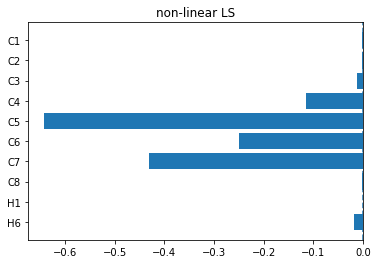

In [92]:
plt.barh(chx_str[::-1], coef_glob[::-1]) # flip order
plt.axvline(ls='--')
plt.title('non-linear LS')
plt.show()

### Final constrained model

The linear least squares model makes use of the linear nature of the problem and gives a global solution without relying on a specific starting point, which proved to give skewed results (a lot of zero-valued coefficients). At the same time, the possibility of applying bounds makes it very flexible and allows to impose the constraints we are looking for ($\theta\le0$).

In [93]:
def constrained_model(region, delay=12, print=False, label=beta):
  '''Policy effect on cases based on constrained linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  # divide the pandemic into subranges
  ta_i = _get_init_date(region)
  t_idx = pd.date_range(start=ta_i, end=tb, freq='2M')

  X = []; y = []; score = []; coef = []
  # apply the model to each subrange
  for i in range(len(t_idx) - 2):
    X_raw, y_raw = data_from(region, t_idx[i], t_idx[i + 1], None, delay, label)
    X_i, y_i = preprocess(X_raw, y_raw)
    X_train, X_test, y_train, y_test = train_test_split(
        X_i, y_i, test_size=0.2, random_state=rs
    )

    coef_i = lsq_linear(X_train, y_train, bounds=bounds)['x']

    y_pred = X_test @ coef_i # matrix multiplication
    score_i = r2_score(y_true=y_test, y_pred=y_pred)
    
    # aggregate model results
    X.append(X_i)
    y.append(y_i)
    score.append(score_i)
    coef.append(coef_i)
  
  score = np.asarray(score).mean()
  coef_values = np.asarray(coef).mean(axis=0)
  coef_names = X_i.columns.values

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return coef, X, y, score

In [94]:
coef_glob = []; coef_intv = []; r_sq = [];
for k in cc_dict.keys():
  c_k, X_k, y_k, r_k = constrained_model(k)
  # each model is defined in segments (invervals)
  coef_k = np.asarray(c_k)[:, :-1]
  coef_glob.append(coef_k.mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))        # individual
  r_sq.append(r_k)

In [95]:
np.asarray(r_sq).mean()

0.9049437911975062

In [ ]:
np.asarray(r_sq).var()

In [96]:
for r_i in r_sq:
  print(round(r_i, 2))

0.88
0.94
0.92
0.93
0.97
0.92
0.74
0.92
0.92
0.93
0.98
0.88
0.78
0.96


In [97]:
coef_glob = np.asarray(coef_glob).mean(axis=0)
for string, value in zip(idch, coef_glob):
  name = string.split('_')[1]
  print(f'{name:33} -> {value:5f}')

School closing                    -> -0.002183
Workplace closing                 -> -0.002949
Cancel public events              -> -0.001635
Restrictions on gatherings        -> -0.005219
Close public transport            -> -0.026803
Stay at home requirements         -> -0.008667
Restrictions on internal movement -> -0.014278
International travel controls     -> -0.001265
Public information campaigns      -> -0.000472
Facial Coverings                  -> -0.009874


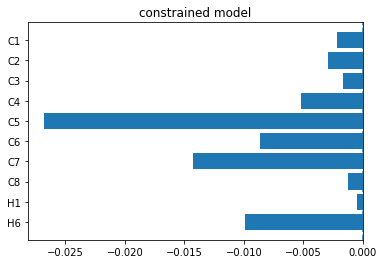

In [98]:
plt.barh(chx_str[::-1], coef_glob[::-1]) # flip order
plt.axvline(ls='--')
plt.title('constrained model')
plt.show()

In [99]:
# can't convert to array directly: variable interval size
# (arrays have fixed length)
# need to traverse the whole nested list...
n = len(coef_intv)         # fixed (no. countries)
m = np.zeros(n, dtype=int) # variable (no. intervals)
l = len(chx_str)           # fixed (no. policies)
for i in range(n):
  m[i] = len(coef_intv[i])

dim = m.max()
# ...and fill empty positions as NaN
for v in coef_intv:
  if(len(v) < dim):
    v += [[np.nan] * l] * (dim - len(v))

In [100]:
coef_intv = np.asarray(coef_intv)
print(coef_intv.shape)
coef_intv = coef_intv.mean(axis=0)
print(coef_intv.shape)

(14, 9, 10)
(9, 10)


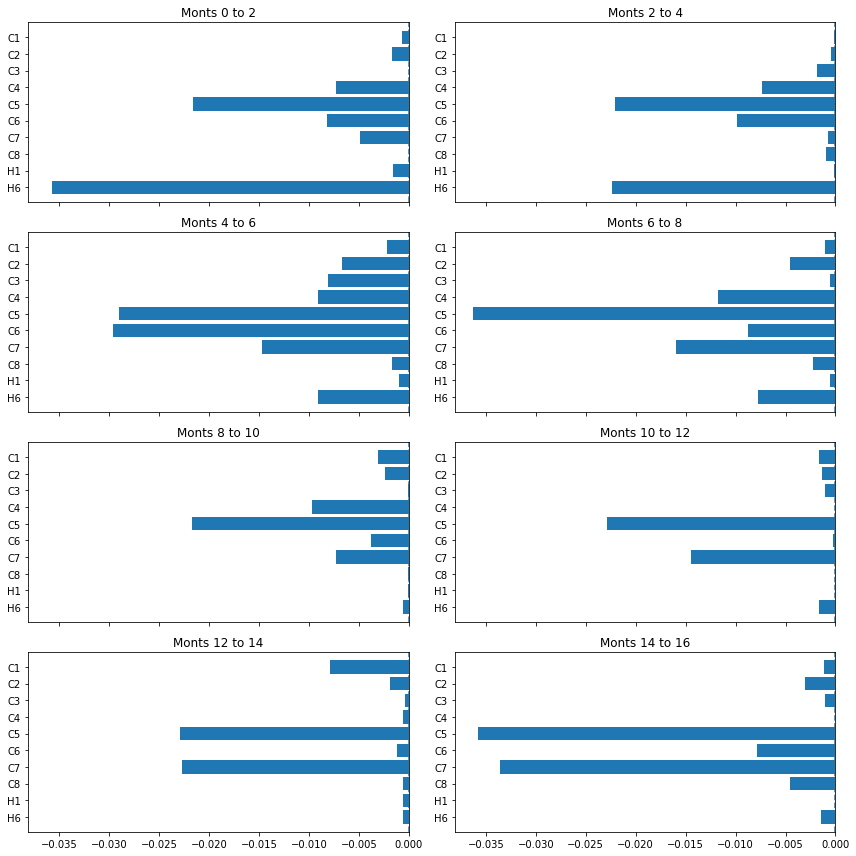

In [101]:
fig, axs = plt.subplots(nrows=dim//2, ncols=2, sharex=True, figsize=(12, 12))

n = 0
# don't use the last interval with less samples
for intv in coef_intv[:-1]:
  axs[n//2, n%2].barh(chx_str[::-1], intv[::-1]) # flip order
  axs[n//2, n%2].axvline(ls='--')
  axs[n//2, n%2].set_title('Monts {} to {}'.format(n*2, (n+1)*2))
  n += 1

fig.tight_layout()
fig.show()

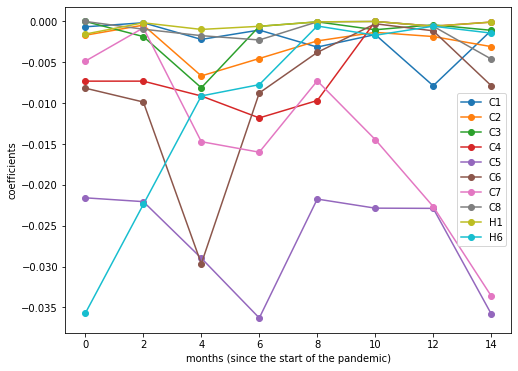

In [102]:
size_ratio = 1.25
plt.figure(figsize=[6.4*size_ratio, 4.8*size_ratio])
plt.plot(range(0, dim * 2, 2), coef_intv, 'o-')
plt.xlabel('months (since the start of the pandemic)')
plt.ylabel('coefficients')
plt.legend(chx_str)
plt.show()

In [103]:
for i in idch:
  print(i.replace('_', ' >> '))

C1 >> School closing
C2 >> Workplace closing
C3 >> Cancel public events
C4 >> Restrictions on gatherings
C5 >> Close public transport
C6 >> Stay at home requirements
C7 >> Restrictions on internal movement
C8 >> International travel controls
H1 >> Public information campaigns
H6 >> Facial Coverings


In [104]:
idx = -2 # country index
cci = list(cc_dict.keys())[idx]
linear_model(cci, print=True)

Coefficients
------------
C1 : 0.017113
C2 : -0.007720
C3 : -0.018298
C5 : -0.000157
C6 : -0.003146
C7 : -0.002663
H1 : -0.002261
prev : 0.849384

R^2
---
0.769


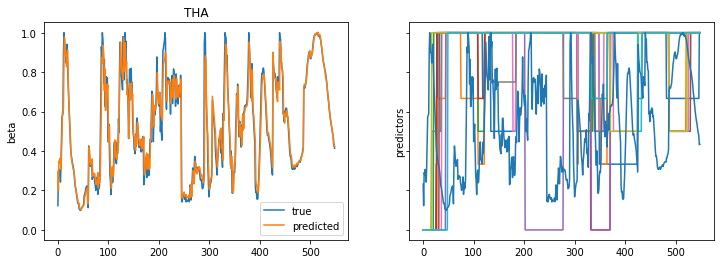

In [105]:
models, Xs, ys = linear_model(cci)[:3]

preds = []
for model, X, y in zip(models, Xs, ys):
  pred_i = model.predict(X)
  preds.append(pred_i)

# array format
X = np.vstack(Xs)
y = np.concatenate(ys)
pred = np.concatenate(preds)

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(12, 4))
axs[0].plot(y, label='true')
axs[0].plot(pred, label='predicted')
axs[0].set_ylabel('beta')
axs[0].set_title(cci)
axs[0].legend()
axs[1].plot(X)
axs[1].set_ylabel('predictors')
plt.show()

### Alternative beta definitions

The value of $β$ is not supposed to change rapidly over time (**careful with the meaning of $\beta$ in this model!**).
Two different strategies to assess the (moderate) changes in $\beta$ are:

* Smoothing $\beta$ over long periods of time (over a week).
* Computing piece-wise linear (B-splines) or piece-wise constant curves for $\beta$.



#### Smoothing

In [106]:
beta_smooth = beta.rolling(window=10, min_periods=1).mean()

In [107]:
coef_glob = []; coef_intv = []; r_sq = [];
for k in cc_dict.keys():
  c_k, X_k, y_k, r_k = constrained_model(k, label=beta_smooth)
  # each model is defined in segments (invervals)
  coef_k = np.asarray(c_k)[:, :-1]
  coef_glob.append(coef_k.mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))        # individual
  r_sq.append(r_k)

In [108]:
np.asarray(r_sq).mean()

0.9808187836384479

In [109]:
np.asarray(r_sq).var()

8.929811497789194e-05

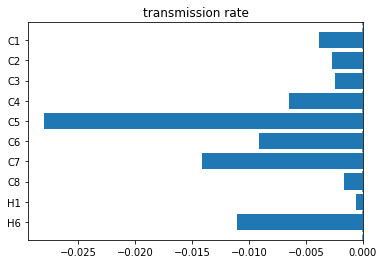

In [110]:
coef_glob = np.asarray(coef_glob).mean(axis=0)

plt.barh(chx_str[::-1], coef_glob[::-1]) # flip order
plt.axvline(ls='--')
plt.title('transmission rate')
plt.show()

In [111]:
# can't convert to array directly: variable interval size
# (arrays have fixed length)
# need to traverse the whole nested list...
n = len(coef_intv)         # fixed (no. countries)
m = np.zeros(n, dtype=int) # variable (no. intervals)
l = len(chx_str)           # fixed (no. policies)
for i in range(n):
  m[i] = len(coef_intv[i])

dim = m.max()
# ...and fill empty positions as NaN
for v in coef_intv:
  if(len(v) < dim):
    v += [[np.nan] * l] * (dim - len(v))

In [112]:
coef_intv = np.asarray(coef_intv)
print(coef_intv.shape)
coef_intv = coef_intv.mean(axis=0)
print(coef_intv.shape)

(14, 9, 10)
(9, 10)


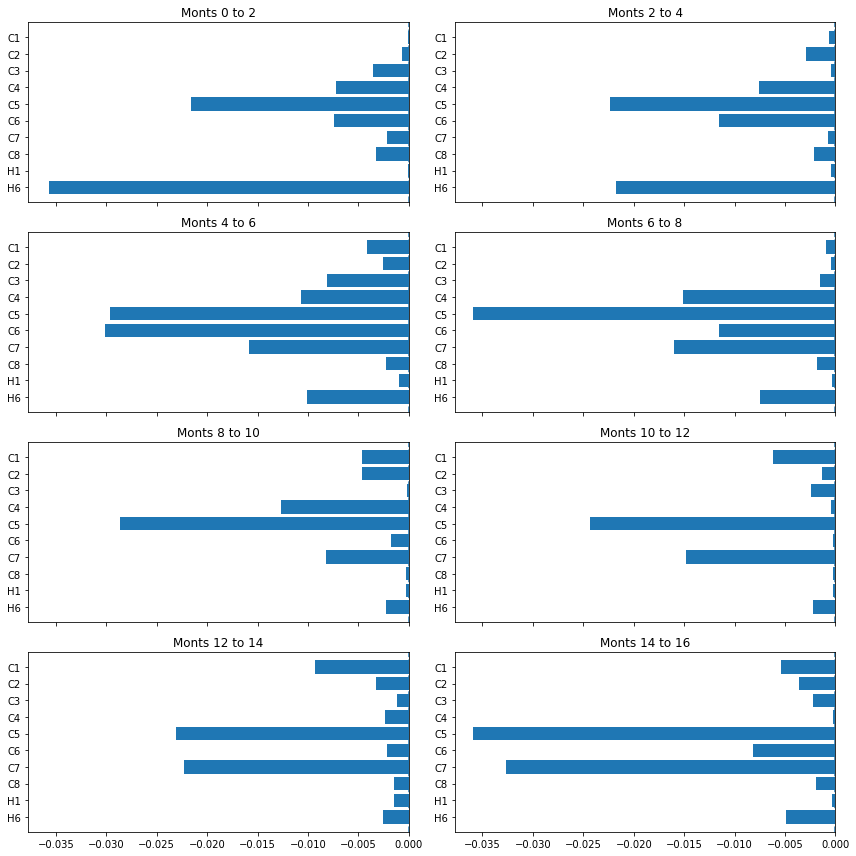

In [113]:
fig, axs = plt.subplots(nrows=dim//2, ncols=2, sharex=True, figsize=(12, 12))

n = 0
# don't use the last interval with less samples
for intv in coef_intv[:-1]:
  axs[n//2, n%2].barh(chx_str[::-1], intv[::-1]) # flip order
  axs[n//2, n%2].axvline(ls='--')
  axs[n//2, n%2].set_title('Monts {} to {}'.format(n*2, (n+1)*2))
  n += 1

fig.tight_layout()
fig.show()

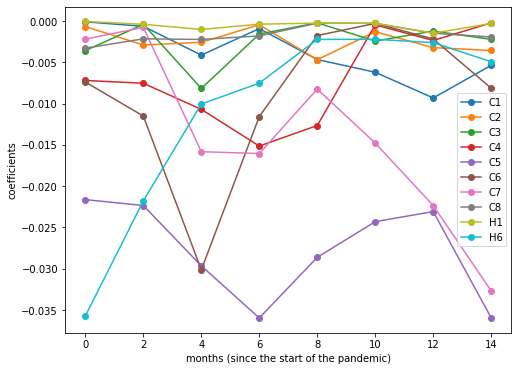

In [114]:
size_ratio = 1.25
plt.figure(figsize=[6.4*size_ratio, 4.8*size_ratio])
plt.plot(range(0, dim * 2, 2), coef_intv, 'o-')
plt.xlabel('months (since the start of the pandemic)')
plt.ylabel('coefficients')
plt.legend(chx_str)
plt.show()

#### Piece-wise constant

In [115]:
beta_rs = beta.resample('1M', label='left').mean()
beta_cst = beta_rs.resample('1d').pad()
beta_cst = beta_cst[ta:tb] # upsampling expands the date range

In [116]:
coef_glob = []; coef_intv = []; r_sq = [];
for k in cc_dict.keys():
  c_k, X_k, y_k, r_k = constrained_model(k, label=beta_cst)
  # each model is defined in segments (invervals)
  coef_k = np.asarray(c_k)[:, :-1]
  coef_glob.append(coef_k.mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))        # individual
  r_sq.append(r_k)

In [117]:
np.asarray(r_sq).mean()

-0.7015823432281378

In [118]:
np.asarray(r_sq).var()

13.603258785694402

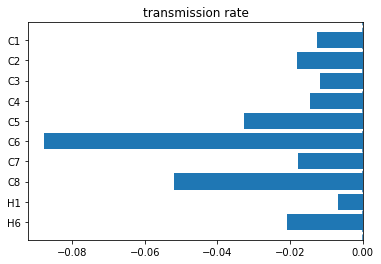

In [119]:
coef_glob = np.asarray(coef_glob).mean(axis=0)

plt.barh(chx_str[::-1], coef_glob[::-1]) # flip order
plt.axvline(ls='--')
plt.title('transmission rate')
plt.show()

In [120]:
# can't convert to array directly: variable interval size
# (arrays have fixed length)
# need to traverse the whole nested list...
n = len(coef_intv)         # fixed (no. countries)
m = np.zeros(n, dtype=int) # variable (no. intervals)
l = len(chx_str)           # fixed (no. policies)
for i in range(n):
  m[i] = len(coef_intv[i])

dim = m.max()
# ...and fill empty positions as NaN
for v in coef_intv:
  if(len(v) < dim):
    v += [[np.nan] * l] * (dim - len(v))

In [121]:
coef_intv = np.asarray(coef_intv)
print(coef_intv.shape)
coef_intv = coef_intv.mean(axis=0)
print(coef_intv.shape)

(14, 9, 10)
(9, 10)


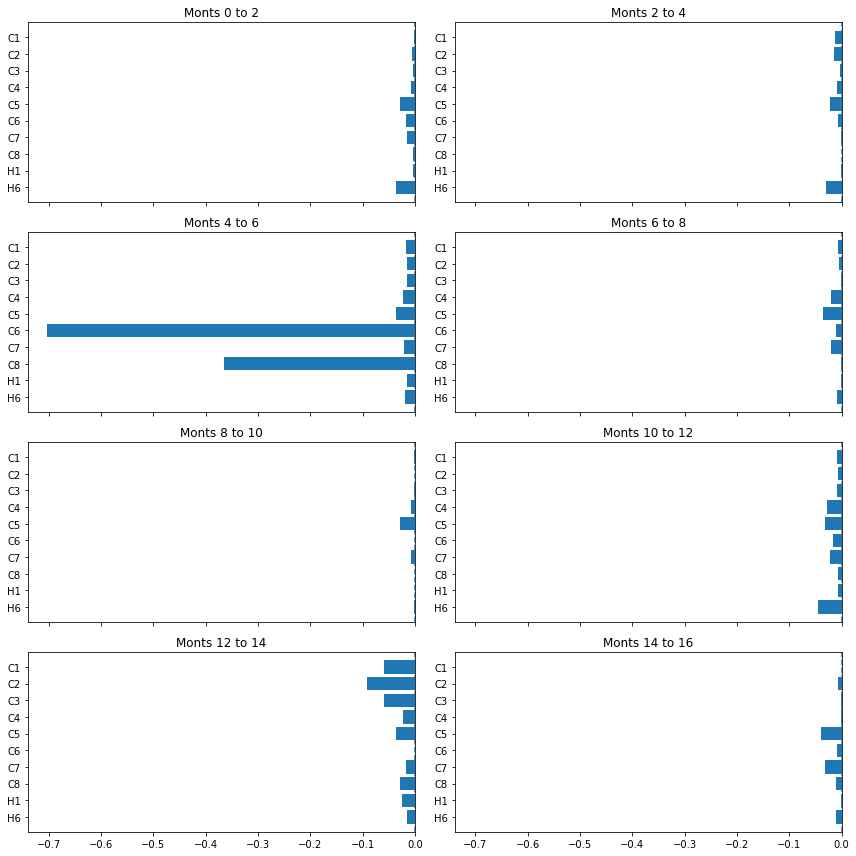

In [122]:
fig, axs = plt.subplots(nrows=dim//2, ncols=2, sharex=True, figsize=(12, 12))

n = 0
# don't use the last interval with less samples
for intv in coef_intv[:-1]:
  axs[n//2, n%2].barh(chx_str[::-1], intv[::-1]) # flip order
  axs[n//2, n%2].axvline(ls='--')
  axs[n//2, n%2].set_title('Monts {} to {}'.format(n*2, (n+1)*2))
  n += 1

fig.tight_layout()
fig.show()

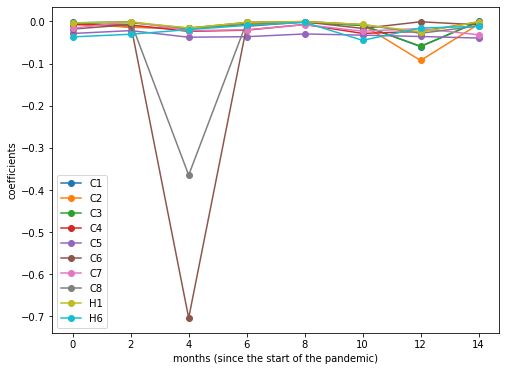

In [123]:
size_ratio = 1.25
plt.figure(figsize=[6.4*size_ratio, 4.8*size_ratio])
plt.plot(range(0, dim * 2, 2), coef_intv, 'o-')
plt.xlabel('months (since the start of the pandemic)')
plt.ylabel('coefficients')
plt.legend(chx_str)
plt.show()

#### Piece-wise linear

In [124]:
beta_lin = beta.copy()

for cn in cc_dict.values():
  x = range(beta.shape[0])
  y = beta[cn]
  y[y.isna()] = 0

  n_pwlf = pwlf.PiecewiseLinFit(x, y)
  # can't control were the knots will be!
  knots = n_pwlf.fit(beta.shape[0] // 30) 
  beta_lin[cn] = n_pwlf.predict(x)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


In [125]:
coef_glob = []; coef_intv = []; r_sq = [];
for k in cc_dict.keys():
  c_k, X_k, y_k, r_k = constrained_model(k, label=beta_lin)
  # each model is defined in segments (invervals)
  coef_k = np.asarray(c_k)[:, :-1]
  coef_glob.append(coef_k.mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))        # individual
  r_sq.append(r_k)

In [126]:
np.asarray(r_sq).mean()

0.9782899347034386

In [127]:
np.asarray(r_sq).var()

0.0009588726246989694

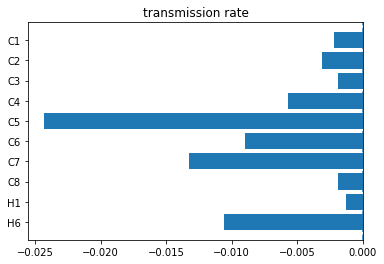

In [128]:
coef_glob = np.asarray(coef_glob).mean(axis=0)

plt.barh(chx_str[::-1], coef_glob[::-1]) # flip order
plt.axvline(ls='--')
plt.title('transmission rate')
plt.show()

In [129]:
# can't convert to array directly: variable interval size
# (arrays have fixed length)
# need to traverse the whole nested list...
n = len(coef_intv)         # fixed (no. countries)
m = np.zeros(n, dtype=int) # variable (no. intervals)
l = len(chx_str)           # fixed (no. policies)
for i in range(n):
  m[i] = len(coef_intv[i])

dim = m.max()
# ...and fill empty positions as NaN
for v in coef_intv:
  if(len(v) < dim):
    v += [[np.nan] * l] * (dim - len(v))

In [130]:
coef_intv = np.asarray(coef_intv)
print(coef_intv.shape)
coef_intv = coef_intv.mean(axis=0)
print(coef_intv.shape)

(14, 9, 10)
(9, 10)


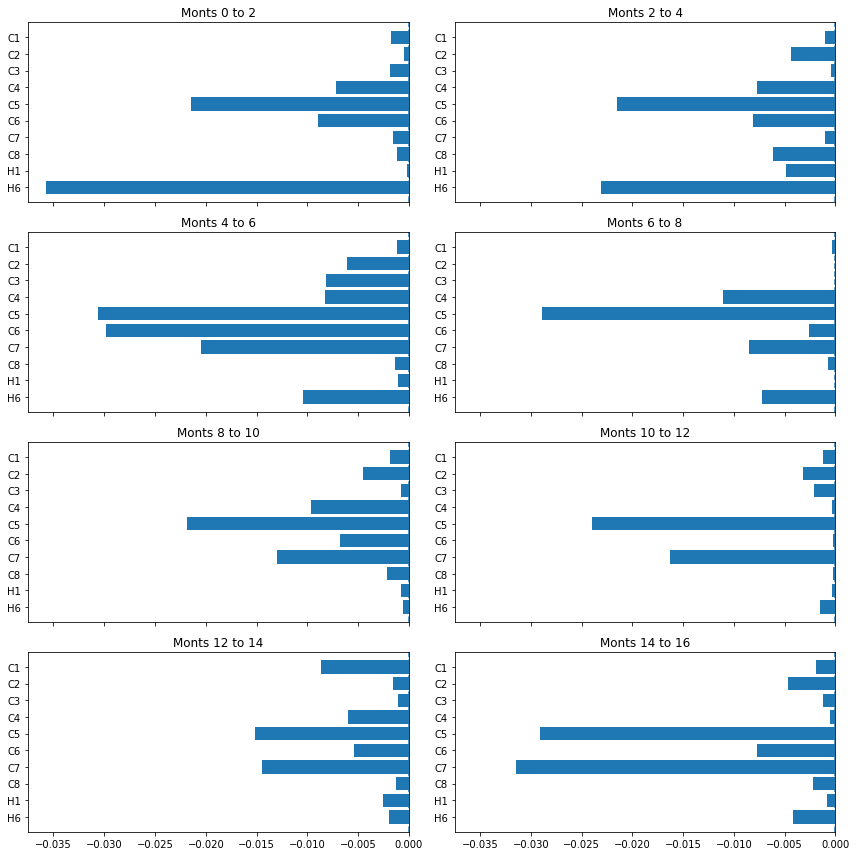

In [131]:
fig, axs = plt.subplots(nrows=dim//2, ncols=2, sharex=True, figsize=(12, 12))

n = 0
# don't use the last interval with less samples
for intv in coef_intv[:-1]:
  axs[n//2, n%2].barh(chx_str[::-1], intv[::-1]) # flip order
  axs[n//2, n%2].axvline(ls='--')
  axs[n//2, n%2].set_title('Monts {} to {}'.format(n*2, (n+1)*2))
  n += 1

fig.tight_layout()
fig.show()

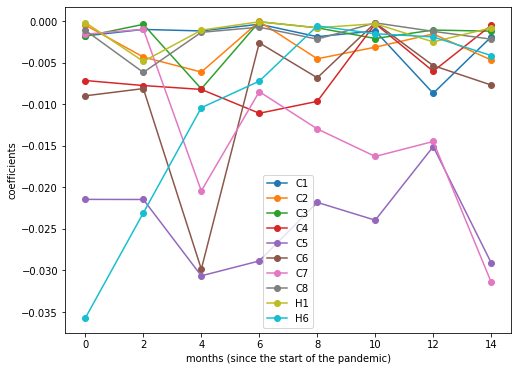

In [132]:
size_ratio = 1.25
plt.figure(figsize=[6.4*size_ratio, 4.8*size_ratio])
plt.plot(range(0, dim * 2, 2), coef_intv, 'o-')
plt.xlabel('months (since the start of the pandemic)')
plt.ylabel('coefficients')
plt.legend(chx_str)
plt.show()

#### Cubic splines

In [133]:
beta_spl = beta.copy()

for cn in cc_dict.values():
  x = range(beta.shape[0])
  y = beta_rs[cn]
  y[y.isna()] = 0
  knots = range(0, x[-1], 30)

  spl = splrep(knots, y)       # representation
  beta_spl[cn] = splev(x, spl) # evaluation

In [134]:
coef_glob = []; coef_intv = []; r_sq = [];
for k in cc_dict.keys():
  c_k, X_k, y_k, r_k = constrained_model(k, label=beta_spl)
  # each model is defined in segments (invervals)
  coef_k = np.asarray(c_k)[:, :-1]
  coef_glob.append(coef_k.mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))        # individual
  r_sq.append(r_k)

In [135]:
np.asarray(r_sq).mean()

0.9944512715777301

In [136]:
np.asarray(r_sq).var()

1.5590320241636403e-05

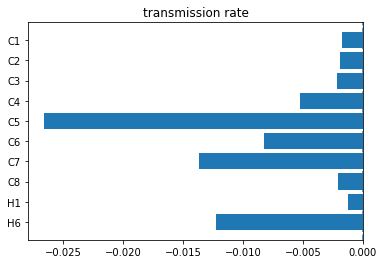

In [137]:
coef_glob = np.asarray(coef_glob).mean(axis=0)

plt.barh(chx_str[::-1], coef_glob[::-1]) # flip order
plt.axvline(ls='--')
plt.title('transmission rate')
plt.show()

In [138]:
# can't convert to array directly: variable interval size
# (arrays have fixed length)
# need to traverse the whole nested list...
n = len(coef_intv)         # fixed (no. countries)
m = np.zeros(n, dtype=int) # variable (no. intervals)
l = len(chx_str)           # fixed (no. policies)
for i in range(n):
  m[i] = len(coef_intv[i])

dim = m.max()
# ...and fill empty positions as NaN
for v in coef_intv:
  if(len(v) < dim):
    v += [[np.nan] * l] * (dim - len(v))

In [139]:
coef_intv = np.asarray(coef_intv)
print(coef_intv.shape)
coef_intv = coef_intv.mean(axis=0)
print(coef_intv.shape)

(14, 9, 10)
(9, 10)


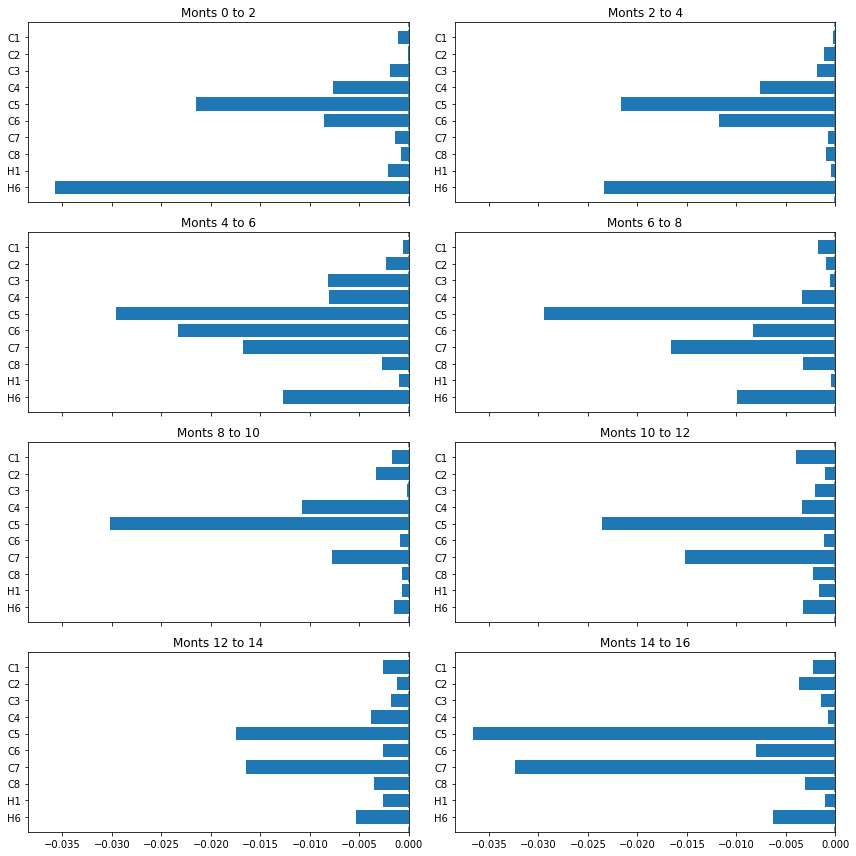

In [140]:
fig, axs = plt.subplots(nrows=dim//2, ncols=2, sharex=True, figsize=(12, 12))

n = 0
# don't use the last interval with less samples
for intv in coef_intv[:-1]:
  axs[n//2, n%2].barh(chx_str[::-1], intv[::-1]) # flip order
  axs[n//2, n%2].axvline(ls='--')
  axs[n//2, n%2].set_title('Monts {} to {}'.format(n*2, (n+1)*2))
  n += 1

fig.tight_layout()
fig.show()

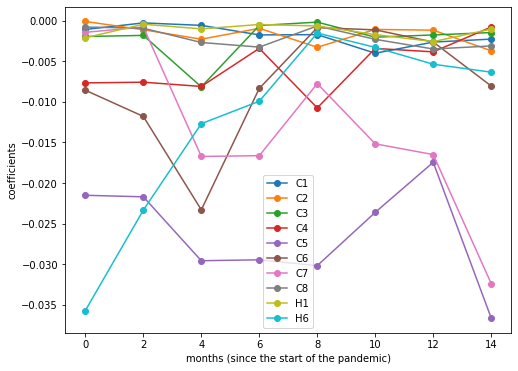

In [141]:
size_ratio = 1.25
plt.figure(figsize=[6.4*size_ratio, 4.8*size_ratio])
plt.plot(range(0, dim * 2, 2), coef_intv, 'o-')
plt.xlabel('months (since the start of the pandemic)')
plt.ylabel('coefficients')
plt.legend(chx_str)
plt.show()

## Trials

Efficiency of applying weights to policy indicators in accordance to the proportion of the population who is affected by the policies.

In [142]:
tot_dict = {
    code: name for code, name in zip(
        oxcgrt_sub['CountryCode'].unique(), 
        oxcgrt_sub['CountryName'].unique()
    )
}
tot_dict['USA'] = 'US'
tot_dict

{'BRA': 'Brazil',
 'CAN': 'Canada',
 'CHN': 'China',
 'GBR': 'United Kingdom',
 'USA': 'US'}

In [143]:
sub_dict = {rc: rc.split('_')[0] for rc in oxcgrt_sub['RegionCode'].unique()}
for key in sub_dict.keys():
  # correct country codes
  sub_dict[key] = sub_dict[key].replace('BR', 'BRA')
  sub_dict[key] = sub_dict[key].replace('UK', 'GBR')
  sub_dict[key] = sub_dict[key].replace('US', 'USA')
sub_dict

{'BR_AC': 'BRA',
 'BR_AL': 'BRA',
 'BR_AM': 'BRA',
 'BR_AP': 'BRA',
 'BR_BA': 'BRA',
 'BR_CE': 'BRA',
 'BR_DF': 'BRA',
 'BR_ES': 'BRA',
 'BR_GO': 'BRA',
 'BR_MA': 'BRA',
 'BR_MG': 'BRA',
 'BR_MS': 'BRA',
 'BR_MT': 'BRA',
 'BR_PA': 'BRA',
 'BR_PB': 'BRA',
 'BR_PE': 'BRA',
 'BR_PI': 'BRA',
 'BR_PR': 'BRA',
 'BR_RJ': 'BRA',
 'BR_RN': 'BRA',
 'BR_RO': 'BRA',
 'BR_RR': 'BRA',
 'BR_RS': 'BRA',
 'BR_SC': 'BRA',
 'BR_SE': 'BRA',
 'BR_SP': 'BRA',
 'BR_TO': 'BRA',
 'CAN_AB': 'CAN',
 'CAN_BC': 'CAN',
 'CAN_MB': 'CAN',
 'CAN_NB': 'CAN',
 'CAN_NL': 'CAN',
 'CAN_NS': 'CAN',
 'CAN_NT': 'CAN',
 'CAN_NU': 'CAN',
 'CAN_ON': 'CAN',
 'CAN_PE': 'CAN',
 'CAN_QC': 'CAN',
 'CAN_SK': 'CAN',
 'CAN_YT': 'CAN',
 'CHN_AH': 'CHN',
 'CHN_BJ': 'CHN',
 'CHN_CQ': 'CHN',
 'CHN_FJ': 'CHN',
 'CHN_GD': 'CHN',
 'CHN_GS': 'CHN',
 'CHN_GX': 'CHN',
 'CHN_GZ': 'CHN',
 'CHN_HA': 'CHN',
 'CHN_HB': 'CHN',
 'CHN_HE': 'CHN',
 'CHN_HI': 'CHN',
 'CHN_HL': 'CHN',
 'CHN_HN': 'CHN',
 'CHN_JL': 'CHN',
 'CHN_JS': 'CHN',
 'CHN_JX': 'CHN',
 

In [144]:
for code, name in zip(oxcgrt_sub['RegionCode'].unique(), oxcgrt_sub['RegionName'].unique()):
  print(code, '<->', name)

BR_AC <-> Acre
BR_AL <-> Alagoas
BR_AM <-> Amazonas
BR_AP <-> Amapa
BR_BA <-> Bahia
BR_CE <-> Ceara
BR_DF <-> Distrito Federal
BR_ES <-> Espirito Santo
BR_GO <-> Goias
BR_MA <-> Maranhao
BR_MG <-> Minas Gerais
BR_MS <-> Mato Grosso do Sul
BR_MT <-> Mato Grosso
BR_PA <-> Para
BR_PB <-> Paraiba
BR_PE <-> Pernambuco
BR_PI <-> Piaui
BR_PR <-> Parana
BR_RJ <-> Rio de Janeiro
BR_RN <-> Rio Grande do Norte
BR_RO <-> Rondonia
BR_RR <-> Roraima
BR_RS <-> Rio Grande do Sul
BR_SC <-> Santa Catarina
BR_SE <-> Sergipe
BR_SP <-> Sao Paulo
BR_TO <-> Tocantins
CAN_AB <-> Alberta
CAN_BC <-> British Columbia
CAN_MB <-> Manitoba
CAN_NB <-> New Brunswick
CAN_NL <-> Newfoundland and Labrador
CAN_NS <-> Nova Scotia
CAN_NT <-> Northwest Territories
CAN_NU <-> Nunavut
CAN_ON <-> Ontario
CAN_PE <-> Prince Edward Island
CAN_QC <-> Quebec
CAN_SK <-> Saskatchewan
CAN_YT <-> Yukon
CHN_AH <-> Anhui
CHN_BJ <-> Beijing
CHN_CQ <-> Chongqing
CHN_FJ <-> Fujian
CHN_GD <-> Guangdong
CHN_GS <-> Gansu
CHN_GX <-> Guangxi
CHN

In [145]:
# https://worldpopulationreview.com/countries
tot_pop = {
    'BRA': 212559417,
    'CAN': 37742154,
    'CHN': 1439323776,
    'GBR': 67886011,
    'USA': 331002651
}

# https://en.wikipedia.org/wiki/List_of_Brazilian_states_by_population
# https://worldpopulationreview.com/canadian-provinces
# https://en.wikipedia.org/wiki/List_of_Chinese_administrative_divisions_by_population
# https://en.wikipedia.org/wiki/Countries_of_the_United_Kingdom_by_population (2019)
# https://worldpopulationreview.com/states (2021)
sub_pop = {
    'BR_AC': 894470, 'BR_AL': 3351543, 'BR_AM': 4207714,
    'BR_AP': 861773, 'BR_BA': 14930634, 'BR_CE': 9187103,
    'BR_DF': 3055149, 'BR_ES': 4064052, 'BR_GO': 7113540,
    'BR_MA': 7114598, 'BR_MG': 21292666, 'BR_MS': 2809394,
    'BR_MT': 3526220, 'BR_PA': 8690745, 'BR_PB': 4039277,
    'BR_PE': 9616621, 'BR_PI': 3281480, 'BR_PR': 11516840,
    'BR_RJ': 17366189, 'BR_RN': 3534165, 'BR_RO': 1796460,
    'BR_RR': 631181, 'BR_RS': 11422973, 'BR_SC': 7252502,
    'BR_SE': 2318822, 'BR_SP': 46289333, 'BR_TO': 1590248,
    'CAN_AB': 4428112, 'CAN_BC': 5145851, 'CAN_MB': 1379584,
    'CAN_NB': 781315, 'CAN_NL': 520998, 'CAN_NS': 979115,
    'CAN_NT': 45074, 'CAN_NU': 39285, 'CAN_ON': 14733119,
    'CAN_PE': 159713, 'CAN_QC': 8575779, 'CAN_SK': 1177884,
    'CAN_YT': 42176, 'CHN_AH': 61027171, 'CHN_BJ': 21893095,
    'CHN_CQ': 32054159, 'CHN_FJ': 41540086, 'CHN_GD': 126012510,
    'CHN_GS': 25019831, 'CHN_GX': 50126804, 'CHN_GZ': 38562148,
    'CHN_HA': 99365519, 'CHN_HB': 57752557, 'CHN_HE': 74610235,
    'CHN_HI': 10081232, 'CHN_HL': 31850088, 'CHN_HN': 66444864,
    'CHN_JL': 24073453, 'CHN_JS': 84748016, 'CHN_JX': 45188635,
    'CHN_LN': 42591407, 'CHN_NM': 24049155, 'CHN_NX': 7202654,
    'CHN_QH': 5923957, 'CHN_SC': 83674866, 'CHN_SD': 101527453,
    'CHN_SH': 24870895, 'CHN_SN': 39528999, 'CHN_SX': 34915616,
    'CHN_TJ': 13866009, 'CHN_XJ': 25852345, 'CHN_XZ': 3648100,
    'CHN_YN': 47209277, 'CHN_ZJ': 64567588, 'UK_ENG': 56286961,
    'UK_NIR': 1893667, 'UK_SCO': 5463300, 'UK_WAL': 3152879	,
    'US_AK': 724357, 'US_AL': 4934193, 'US_AR': 3033946,
    'US_AZ': 7520103, 'US_CA': 39613493, 'US_CO': 5893634,
    'US_CT': 3552821, 'US_DC': 714153, 'US_DE': 990334,
    'US_FL': 21944577, 'US_GA': 10830007, 'US_HI': 1406430,
    'US_IA': 3167974, 'US_ID': 1860123, 'US_IL': 12569321,
    'US_IN': 6805663, 'US_KS': 2917224, 'US_KY': 4480713,
    'US_LA': 4627002, 'US_MA': 6912239, 'US_MD': 6065436,
    'US_ME': 1354522, 'US_MI': 9992427, 'US_MN': 5706398,
    'US_MO': 6169038, 'US_MS': 2966407, 'US_MT': 1085004,
    'US_NC': 10701022, 'US_ND': 770026, 'US_NE': 1951996,
    'US_NH': 1372203, 'US_NJ': 8874520, 'US_NM': 2105005,
    'US_NV': 3185786, 'US_NY': 19299981, 'US_OH': 11714618,
    'US_OK': 3990443, 'US_OR': 4289439, 'US_PA': 12804123,
    'US_RI': 1061509, 'US_SC': 5277830, 'US_SD': 896581,
    'US_TN': 6944260, 'US_TX': 29730311, 'US_UT': 3310774,
    'US_VA': 8603985, 'US_VT': 623251, 'US_WA': 7796941,
    'US_WI': 5852490, 'US_WV': 1767859, 'US_WY': 581075
}

In [146]:
sub_prop = {rc: sub_pop[rc] / tot_pop[cc] for rc, cc in sub_dict.items()}
sub_prop

{'BR_AC': 0.004208093965556934,
 'BR_AL': 0.015767558301121986,
 'BR_AM': 0.01979547205852564,
 'BR_AP': 0.004054268741243302,
 'BR_BA': 0.07024216668791484,
 'BR_CE': 0.043221340788679334,
 'BR_DF': 0.014373152895879461,
 'BR_ES': 0.019119604566849184,
 'BR_GO': 0.0334661249094412,
 'BR_MA': 0.03347110234123384,
 'BR_MG': 0.10017277192663734,
 'BR_MS': 0.013216982054481265,
 'BR_MT': 0.016589337935566505,
 'BR_PA': 0.04088619136549476,
 'BR_PB': 0.01900304892161047,
 'BR_PE': 0.04524203695948225,
 'BR_PI': 0.01543794222958374,
 'BR_PR': 0.05418174439196923,
 'BR_RJ': 0.08170039815267277,
 'BR_RN': 0.016626715719680395,
 'BR_RO': 0.008451566274290261,
 'BR_RR': 0.002969433247928037,
 'BR_RS': 0.053740140809663585,
 'BR_SC': 0.034119880936632416,
 'BR_SE': 0.010909053255448099,
 'BR_SP': 0.21777126439897979,
 'BR_TO': 0.007481428122283569,
 'CAN_AB': 0.1173253651606636,
 'CAN_BC': 0.13634227129696944,
 'CAN_MB': 0.036552868710143044,
 'CAN_NB': 0.020701388691276072,
 'CAN_NL': 0.0138041

In [147]:
# REPEAT COMPUTATION OF LABELS
cum_cases_alt = jhu_cases[tot_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_deaths_alt = jhu_death[tot_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_recoveries_alt = jhu_recov[tot_dict.values()].rolling(window, min_periods=1, center=True).mean()

R_alt = cum_deaths_alt + cum_recoveries_alt
I_alt = cum_cases_alt - R_alt
S_alt = tot_pop.values() - cum_cases_alt

i_prop_alt = I_alt / tot_pop.values()
# handle log(0)
warnings.filterwarnings('ignore', category=RuntimeWarning)
log_i_alt = np.log(i_prop_alt)
warnings.resetwarnings()
log_i_alt[np.isinf(log_i_alt)] = 0 # before the pandemic begins, the growth must be zero
gr_alt = log_i_alt[1:] - log_i_alt[:-1].values # different index
gr_alt

Country/Region,Brazil,Canada,China,United Kingdom,US
2020-01-23,0.000000,-19.055726,0.247127,0.000000,0.382992
2020-01-24,0.000000,0.510826,0.237200,0.000000,0.192372
2020-01-25,0.000000,0.538997,0.353038,0.000000,0.117783
2020-01-26,0.000000,0.405465,0.337818,0.000000,0.213574
2020-01-27,0.000000,0.287682,0.328822,0.000000,0.175891
...,...,...,...,...,...
2021-11-21,0.000427,0.001474,0.000252,0.012271,0.002014
2021-11-22,0.000426,0.001590,0.000240,0.010590,0.001785
2021-11-23,0.000171,0.000699,0.000126,0.004642,0.000779
2021-11-24,0.000159,0.000784,0.000138,0.005435,0.000915


Steps to apply the weights;
1. Pivot the original df and construct multilevel columns with region and country.
2. Convert to boolean type to obtain a binary representation.
3. Multiply by the proportional population
4. Stack the region column and group by date, which is equivalent to sum up the proportion of each region.

In [148]:
C1_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[0])
C2_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[1])
C3_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[2])
C4_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[3])
C5_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[4])
C6_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[5])
C7_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[6])
C8_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[7])
H1_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[8])
H6_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[9])

C1_bin = C1_sub.astype(bool) * sub_prop.values()
C2_bin = C2_sub.astype(bool) * sub_prop.values()
C3_bin = C3_sub.astype(bool) * sub_prop.values()
C4_bin = C4_sub.astype(bool) * sub_prop.values()
C5_bin = C5_sub.astype(bool) * sub_prop.values()
C6_bin = C6_sub.astype(bool) * sub_prop.values()
C7_bin = C7_sub.astype(bool) * sub_prop.values()
C8_bin = C8_sub.astype(bool) * sub_prop.values()
H1_bin = H1_sub.astype(bool) * sub_prop.values()
H6_bin = H6_sub.astype(bool) * sub_prop.values()

C1_weights = C1_bin.stack().groupby('Date').sum()
C2_weights = C2_bin.stack().groupby('Date').sum()
C3_weights = C3_bin.stack().groupby('Date').sum()
C4_weights = C4_bin.stack().groupby('Date').sum()
C5_weights = C5_bin.stack().groupby('Date').sum()
C6_weights = C6_bin.stack().groupby('Date').sum()
C7_weights = C7_bin.stack().groupby('Date').sum()
C8_weights = C8_bin.stack().groupby('Date').sum()
H1_weights = H1_bin.stack().groupby('Date').sum()
H6_weights = H6_bin.stack().groupby('Date').sum()

CH_w = [
        C1_weights, C2_weights, C3_weights, C4_weights, C5_weights,
        C6_weights, C7_weights, C8_weights, H1_weights, H6_weights
]

Comparison between the fits with and without applying weights.

In [149]:
def data_from_alt(iso, tr, t_d, y, weight):
  'Select data with location and time constraints.'

  if iso in tot_dict.keys():
    name = tot_dict[iso]
  else:
    raise NameError('Invalid ISO code.')
  
  t0 = cum_cases_alt.loc[cum_cases_alt[name] > 25, name].index.min()
  if t0 < ta:
    t0 = ta # previous value NA otherwise
  prop_case = cum_cases_alt[name] / tot_pop[iso]
  t1 = prop_case[prop_case < tr/100].index.max()
  
  delay = pd.to_timedelta(t_d, unit='days')
  ch_x = [ch.loc[t0 - delay:t1 - delay, iso] for ch in CH_X]
  pol_t = pd.concat(ch_x, axis=1, ignore_index=True)
  if weight:
    # apply policy weights
    ch_w = [ch.loc[t0 - delay:t1 - delay, iso] for ch in CH_w]
    w_t = pd.concat(ch_w, axis=1, ignore_index=True)
    pol_t *= w_t
  
  y_t = y.loc[t0:t1, name]
  
  return pol_t, y_t

In [150]:
def initial_model_weighted(region, tr=1, delay=12, weighted=True, print=False):
  '''Policy effect on cases based on linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - tr (float) : percentage (%) treshold for applying the approximation.
  - delay (int) : expected time (in days) for policies to make an impact.
  - weighted (bool) : wheter to apply weights to the policies.
  - print (bool) : whether to display results via stdout.
  '''

  X_raw, y_raw = data_from_alt(region, tr, delay, gr_alt, weighted)
  X, y = preprocess(X_raw, y_raw) 
  coef_names = X.columns.values
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=rs
  )

  lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
  lasso.fit(X_train, y_train)
  score = lasso.score(X_test, y_test)

  reg = Lasso(alpha=lasso.alpha_).fit(X, y)
  coef_values = reg.coef_

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return reg, X, y, score

Don't apply weights

In [151]:
r_sq = [initial_model_weighted(k, weighted=False)[3] for k in tot_dict.keys()]
print(np.asarray(r_sq).mean())
print(np.asarray(r_sq).var())

0.8276510311670513
0.02178779668399454


In [152]:
idx = 1 # country index
cci = list(tot_dict.keys())[idx]
initial_model_weighted(cci, weighted=False, print=True)

Coefficients
------------
C1 : -0.035980
C3 : -0.027632
C4 : -0.013996
C7 : -0.050769
prev : 0.668227

R^2
---
0.884


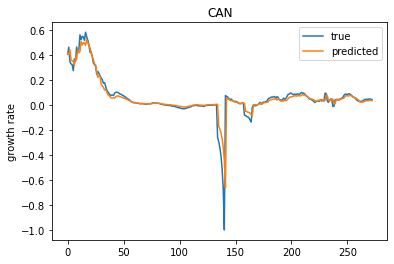

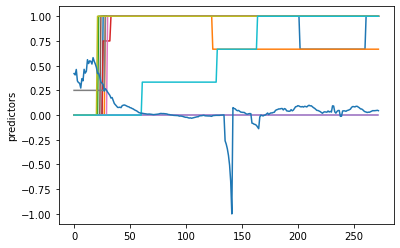

In [153]:
model, X, y = initial_model_weighted(cci, weighted=False)[:3]

plt.plot(y, label='true')
plt.plot(model.predict(X), label='predicted')
plt.ylabel('growth rate')
plt.title(cci)
plt.legend()
X.plot(legend=False)
plt.ylabel('predictors')
plt.show()

Apply weights

In [154]:
r_sq = [initial_model_weighted(k, weighted=True)[3] for k in tot_dict.keys()]
print(np.asarray(r_sq).mean())
print(np.asarray(r_sq).var())

0.8381357700540081
0.01836401870970223


In [155]:
cci = list(tot_dict.keys())[idx]
initial_model_weighted(cci, print=True)

Coefficients
------------
C1 : -0.032601
C3 : -0.022734
C4 : -0.075604
C6 : 0.006807
prev : 0.667570

R^2
---
0.885


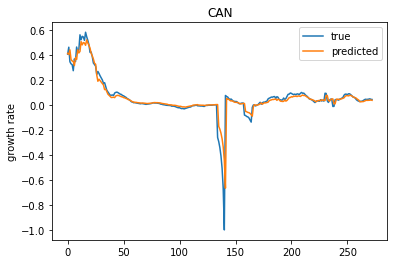

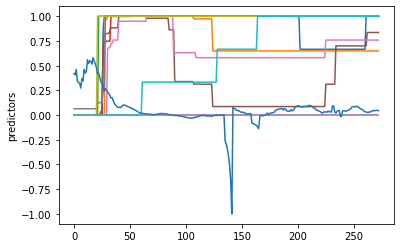

In [156]:
model, X, y = initial_model_weighted(cci)[:3]

plt.plot(y, label='true')
plt.plot(model.predict(X), label='predicted')
plt.ylabel('growth rate')
plt.title(cci)
plt.legend()
X.plot(legend=False)
plt.ylabel('predictors')
plt.show()